# FABRIC Experimenters Workshop: Jupyter/API Demo


## Configure the Environment

### Create the FABRIC Slice Manager

The FABRIC API is used via Slice Manager that manage APIs to the control framework. 

Fabric uses two kinds of tokens:

- Refresh Token: When user logins to Jupyterhub after authenticating against CILogon, an initial refresh token is derived. This token is available as the environment variable `CILOGON_REFRESH_TOKEN` and is used to generate the initial Identity Token. On every refresh, Fabric Refresh Token is changed and updated. Each Refresh Token is valid for 24 hours.

- Identity Token: The control/measurement framework APIs require an Identity Token. Identity tokens can be generated from a valid Refresh Token at any time. Each Identity Token is valid upto an hour.



# Save the Initial Refresh Token

In [1]:
import os
#Retrieve or set the refresh token (exprires 24 hours after login)
fabric_refresh_token=None
%store -r fabric_refresh_token
if fabric_refresh_token is None:
    fabric_refresh_token=os.environ['CILOGON_REFRESH_TOKEN']
    %store fabric_refresh_token

print("Refresh Token: {}".format(fabric_refresh_token))

no stored variable or alias fabric_refresh_token
Stored 'fabric_refresh_token' (str)
Refresh Token: NB2HI4DTHIXS6Y3JNRXWO33OFZXXEZZPN5QXK5DIGIXTINDEG44GCMDEMFQTQMRYGI4WKZTGHE3TSNLDGJQWEODBMUYTGNR7OR4XAZJ5OJSWM4TFONUFI33LMVXCM5DTHUYTMMRSGEZTKMBRGY3TKMJGOZSXE43JN5XD25RSFYYCM3DJMZSXI2LNMU6TQNRUGAYDAMBQ


# Create Slice Manager

In [2]:
import os
import json

from fabrictestbed.slice_manager import SliceManager, Status

credmgr_host = os.environ['FABRIC_CREDMGR_HOST']
orchestrator_host = os.environ['FABRIC_ORCHESTRATOR_HOST']
print(f"CM Host: {credmgr_host} Orchestrator Host: {orchestrator_host}")

# Create Slice Manager
slice_manager = SliceManager(oc_host=orchestrator_host, cm_host=credmgr_host, 
                             refresh_token=fabric_refresh_token, project_name='all', scope='all')

#Cofigure SSH Key
ssh_key = None
with open ("/home/fabric/.ssh/id_rsa.pub", "r") as myfile:
    ssh_key=myfile.read().strip()

CM Host: beta-2.fabric-testbed.net Orchestrator Host: beta-7.fabric-testbed.net


### Refresh the ID Token

ID Tokens expire one hour after refresh. 

In [3]:
try:
    id_token, refresh_token = slice_manager.refresh_tokens()
except Exception as e:
    print("Exception occurred while getting tokens:{}".format(e))

fabric_refresh_token=slice_manager.get_refresh_token()
print()
print("New Refresh Token: {}".format(fabric_refresh_token))
print()
print("Stored new Refresh Token")
%store fabric_refresh_token
print()
print()
    


New Refresh Token: NB2HI4DTHIXS6Y3JNRXWO33OFZXXEZZPN5QXK5DIGIXTCNTBGZQTCZRVMU2WENJXGE3DEMBUME3WCMTFGIYTQYRVMRSGMNB7OR4XAZJ5OJSWM4TFONUFI33LMVXCM5DTHUYTMMRSGEZTKNZRGMZTSMBGOZSXE43JN5XD25RSFYYCM3DJMZSXI2LNMU6TQNRUGAYDAMBQ

Stored new Refresh Token
Stored 'fabric_refresh_token' (str)




## Getting Help

In [4]:
help(SliceManager)

Help on class SliceManager in module fabrictestbed.slice_manager.slice_manager:

class SliceManager(builtins.object)
 |  SliceManager(*, cm_host: str, oc_host: str, refresh_token: str, project_name: str = 'all', scope: str = 'all')
 |  
 |  Implements User facing Control Framework API interface
 |  
 |  Methods defined here:
 |  
 |  __init__(self, *, cm_host: str, oc_host: str, refresh_token: str, project_name: str = 'all', scope: str = 'all')
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  create(self, *, slice_name: str, ssh_key: str, topology: fim.user.topology.ExperimentTopology = None, slice_graph: str = None, lease_end_time: str = None) -> Tuple[fabric_cf.orchestrator.orchestrator_proxy.Status, Union[Exception, List[fabric_cf.orchestrator.elements.reservation.Reservation]]]
 |      Create a slice
 |      @param slice_name slice name
 |      @param ssh_key SSH Key
 |      @param topology Experiment topology
 |      @param slice_graph Slice Graph st

## Query Resource Availability 

### Get Advertisement from Proxy

In [5]:
status, advertised_topology = slice_manager.resources()

print(f"Status: {status}")
print(f"Toplogy: {advertised_topology}")

Status: Status.OK
Toplogy: RENC: { cpu: 6/6, core: 92/96, ram: 1472/1536G, disk: 109100/109600G, unit: 3/3, }
	Components:
		NVME-P4510:  NVME P4510 { disk: 10000/10000G, unit: 10/10, }
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2, }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 4/4, }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 3/3, }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2, }
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 1/2, }
	Site Interfaces:
UKY: { cpu: 6/6, core: 92/96, ram: 1472/1536G, disk: 109100/109600G, unit: 3/3, }
	Components:
		SmartNIC-ConnectX-5:  SmartNIC ConnectX-5 { unit: 2/2, }
		NVME-P4510:  NVME P4510 { disk: 10000/10000G, unit: 10/10, }
		GPU-RTX6000:  GPU RTX6000 { unit: 2/2, }
		GPU-Tesla T4:  GPU Tesla T4 { unit: 3/4, }
		SharedNIC-ConnectX-6:  SharedNIC ConnectX-6 { unit: 3/3, }
		SmartNIC-ConnectX-6:  SmartNIC ConnectX-6 { unit: 2/2, }
	Site Interfaces:
LBNL: { cpu: 6/6, core: 88/96, ram: 1408/1536G, disk: 108600/109600G, unit: 3/3, }
	Co

### Display Resource Topology

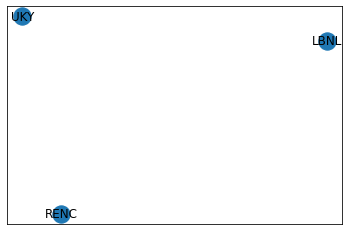

In [6]:
advertised_topology.draw()

## Build Slice Request

<!---
<img src="./figs/AllNodes.png" width="90%"><br>
-->


In [7]:
from fabrictestbed.slice_editor import ExperimentTopology, Capacities, ComponentType, LinkType, Layer

# Create Experiment Topology
experiemnt = ExperimentTopology()

slice_name="DemoSlice"

In [8]:
help(ExperimentTopology)

Help on class ExperimentTopology in module fim.user.topology:

class ExperimentTopology(Topology)
 |  ExperimentTopology(graph_file: str = None, graph_string: str = None, logger=None)
 |  
 |  Define an user topology model, inheriting behavior from Topology class.
 |  In addition to publicly visible methods the following calls can be made:
 |  topology.nodes - a read-only dictionary of nodes in the topology
 |  topology.links - a read-only dictionary of links in the topology
 |  topology.interface_list - a read-only list of all interfaces of all nodes
 |  If you want to operate on top of a Neo4j graph, use the cast() method.
 |  
 |  Method resolution order:
 |      ExperimentTopology
 |      Topology
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, graph_file: str = None, graph_string: str = None, logger=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  cast(self, *, asm_graph: fim.graph.slices.abc_asm.A

### Add Node1 at RENC
<img src="./figs/Node1.png" width="40%"><br>

In [9]:
# Add Node1 with: GPU: 1xSharedConnectX-6, 1xRTX6000, 1xP4510
node1 = experiemnt.add_node(name='node1', site='RENC')

node1_capacity = Capacities()
node1_capacity.set_fields(core=2, ram=16, disk=100)
node1.set_properties(capacities=node1_capacity, image_type='qcow2', image_ref='default_ubuntu_20')

node1_nvme = node1.add_component(ctype=ComponentType.NVME, model='P4510', name='n1_nvme')
node1_gpu  = node1.add_component(ctype=ComponentType.GPU, model='RTX6000', name='n1_gpu')
node1_nic = node1.add_component(ctype=ComponentType.SharedNIC, model='ConnectX-6', name='n1_nic')

### Add Node2 at LBNL
<img src="./figs/Node2.png" width="40%"><br>

In [11]:
# Add Node2 with: FastNet: 2xConnectX-5, 2xT4
node2 = experiemnt.add_node(name='node2', site='LBNL')

node2_capacity = Capacities()
node2_capacity.set_fields(core=4, ram=32, disk=200)
node2.set_properties(capacities=node2_capacity, image_type='qcow2', image_ref='default_ubuntu_20')

node2_gpu1  = node2.add_component(ctype=ComponentType.GPU, model='Tesla T4', name='n2_gpu1')
node2_gpu2  = node2.add_component(ctype=ComponentType.GPU, model='Tesla T4', name='n2_gpu2')
node2_nvme1 = node2.add_component(ctype=ComponentType.SmartNIC, model='ConnectX-5', name='n2_nic1')
node2_nvme2 = node2.add_component(ctype=ComponentType.SmartNIC, model='ConnectX-5', name='n2_nic2')

### Add Node3 at UKY
<img src="./figs/Node3.png" width="40%"><br>

In [ ]:
# Add Node with: SlowNet: 1xConnectX-6, 2xT4, 4xP4510
node3 = experiemnt.add_node(name='node3', site='UKY')

node3_capacity = Capacities()
node3_capacity.set_fields(core=8, ram=64, disk=500)
node3.set_properties(capacities=node3_capacity, image_type='qcow2', image_ref='default_ubuntu_20')

node3_nvme1 = node3.add_component(ctype=ComponentType.NVME, model='P4510', name='n3_nvme1')
node3_nvme2 = node3.add_component(ctype=ComponentType.NVME, model='P4510', name='n3_nvme2')
node3_nvme3 = node3.add_component(ctype=ComponentType.NVME, model='P4510', name='n3_nvme3')
node3_nvme4 = node3.add_component(ctype=ComponentType.NVME, model='P4510', name='n3_nvme4')
node3_gpu1  = node3.add_component(ctype=ComponentType.GPU, model='Tesla T4', name='n3_gpu1')
node3_gpu2  = node3.add_component(ctype=ComponentType.GPU, model='Tesla T4', name='n3_gpu2')
#node3_nic1 = node3.add_component(ctype=ComponentType.SharedNIC, model='ConnectX-6', name='n3_nic1')

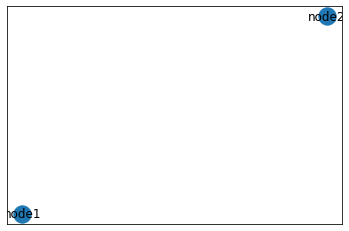

In [12]:
# Generate Slice Graph
#slice_graph = t.serialize()
experiemnt.draw()

## Submit the Request

In [13]:
slice_graph = experiemnt.serialize()

# Request slice from Orchestrator
status, reservations = slice_manager.create(slice_name=slice_name, slice_graph=slice_graph, ssh_key=ssh_key)


print("Request {}".format(status))
slice_id=reservations[0].slice_id

print("Reservations: {}".format(reservations))
print("Slice ID: {}".format(slice_id))

Request Status.OK
Reservations: [{
    "graph_node_id": "a2982249-b992-4d94-9864-a8785fa8387e",
    "join_state": "None_",
    "lease_end": "2021-05-28 17:17:46",
    "reservation_id": "16486ea2-fde0-435b-ac82-ddc933bad7e3",
    "reservation_state": "Unknown",
    "resource_type": "VM",
    "slice_id": "121d5845-e1c2-4292-916e-27b5597b48da"
}, {
    "graph_node_id": "6a6a2536-ce8c-4fa6-bf26-78eac49be933",
    "join_state": "None_",
    "lease_end": "2021-05-28 17:17:46",
    "reservation_id": "2dcb9ce0-fd27-4d4a-862f-8c83023c8c97",
    "reservation_state": "Unknown",
    "resource_type": "VM",
    "slice_id": "121d5845-e1c2-4292-916e-27b5597b48da"
}]
Slice ID: 121d5845-e1c2-4292-916e-27b5597b48da


## Query Slices

In [26]:
status, slices = slice_manager.slices()

print("Response Status {}".format(status))
print("Slices {}".format(slices))

Response Status Status.OK
Slices []


## Slice Status

In [27]:
import time

slice_state=None
while slice_state != 'StableOK':
    status, slice_status = slice_manager.slice_status(slice_id=slice_id)
    slice_state = slice_status.slice_state
    print("Response Status {}".format(status))
    print("Slice State: {}".format(slices[0].slice_state))
    time.sleep(20)

#status, slice_status = orchestrator_proxy.slice_status(token=fabric_id_token, slice_id=slice_id)

print("Response Status {}".format(status))
print("Slice Status {}".format(slice_status))

Response Status Status.OK


IndexError: list index out of range

## Query Slivers

In [21]:
status, slivers = slice_manager.slivers(slice_id=slice_id)

print("Response Status {}".format(status))
print("Slivers {}".format(reservations))

Response Status Status.OK
Slivers [{
    "graph_node_id": "a2982249-b992-4d94-9864-a8785fa8387e",
    "join_state": "None_",
    "lease_end": "2021-05-28 17:17:46",
    "reservation_id": "16486ea2-fde0-435b-ac82-ddc933bad7e3",
    "reservation_state": "Unknown",
    "resource_type": "VM",
    "slice_id": "121d5845-e1c2-4292-916e-27b5597b48da"
}, {
    "graph_node_id": "6a6a2536-ce8c-4fa6-bf26-78eac49be933",
    "join_state": "None_",
    "lease_end": "2021-05-28 17:17:46",
    "reservation_id": "2dcb9ce0-fd27-4d4a-862f-8c83023c8c97",
    "reservation_state": "Unknown",
    "resource_type": "VM",
    "slice_id": "121d5845-e1c2-4292-916e-27b5597b48da"
}]


## Sliver Status

In [22]:
for sliver in slivers:
    sliver_id=sliver.reservation_id
    status, reservation_status = slice_manager.sliver_status(slice_id=slice_id, sliver_id=sliver_id)

    print("Response Status {}".format(status))
    print("Reservation Status {}".format(reservation_status))

Response Status Status.OK
Reservation Status {
    "capacities": "{\"core\": 2, \"disk\": 100, \"ram\": 16}",
    "graph_node_id": "a2982249-b992-4d94-9864-a8785fa8387e",
    "join_state": "NoJoin",
    "labels": "",
    "lease_end": "2021-05-28 17:17:46",
    "name": "node1",
    "notices": "Reservation 16486ea2-fde0-435b-ac82-ddc933bad7e3 (Slice DemoSlice(121d5845-e1c2-4292-916e-27b5597b48da) Graph Id:05bf1194-b7bf-4e5c-a6d2-a36acbaa658a ) is in state [CloseWait,None_]\n\nLast ticket update: \nTicket events: \nLast ticket update: \nTicket events: ",
    "reservation_id": "16486ea2-fde0-435b-ac82-ddc933bad7e3",
    "reservation_state": "CloseWait",
    "resource_type": "VM",
    "site": "RENC",
    "slice_id": "121d5845-e1c2-4292-916e-27b5597b48da"
}
Response Status Status.OK
Reservation Status {
    "capacities": "{\"core\": 4, \"disk\": 200, \"ram\": 32}",
    "graph_node_id": "6a6a2536-ce8c-4fa6-bf26-78eac49be933",
    "join_state": "NoJoin",
    "labels": "",
    "lease_end": "202

## Configure the Nodes

In [23]:
script= '#!/bin/bash  \n' \
        'lspci  \n'

In [24]:
import paramiko 
#from scp import SCPClient, SCPException

key = paramiko.RSAKey.from_private_key_file("/home/fabric/.ssh/id_rsa")
client = paramiko.SSHClient()
client.load_system_host_keys()
client.set_missing_host_key_policy(paramiko.MissingHostKeyPolicy())

client.set_missing_host_key_policy(paramiko.AutoAddPolicy())

for sliver in slivers:
    node_name = sliver.name
    management_ip = sliver.management_ip
    
    print("Node {0} IP {1}".format(node_name, management_ip))
    
    client.connect(management_ip,username='ubuntu',pkey = key)

    stdin, stdout, stderr = client.exec_command('echo \"' + script + '\" > script.sh; chmod +x script.sh; sudo ./script.sh')
    print ('')
    print (str(stdout.read(),'utf-8').replace('\\n','\n'))

    client.close()

Node node1 IP None


NoValidConnectionsError: [Errno None] Unable to connect to port 22 on 127.0.0.1 or ::1

## Delete Slice

In [25]:
status, result = slice_manager.delete(slice_id=slice_id)

print("Response Status {}".format(status))
print("Response received {}".format(result))

Response Status Status.FAILURE
Response received (400)
Reason: BAD REQUEST
HTTP response headers: HTTPHeaderDict({'Server': 'nginx/1.19.8', 'Date': 'Thu, 27 May 2021 17:37:02 GMT', 'Content-Type': 'application/json', 'Content-Length': '61', 'Connection': 'keep-alive'})
HTTP response body: "Slice# 121d5845-e1c2-4292-916e-27b5597b48da already closed"


